In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('/home/rebeca/Escritorio/Master thesis/Report/SFE_signals.xlsx', sheet_name='Sheet8')
print(df.head())

   Label      x      y      z     rx     ry     rz
0      1  0.048  0.003 -0.003 -0.024 -0.106  0.032
1      1  0.048  0.002 -0.003 -0.029 -0.107  0.029
2      1  0.047  0.002 -0.003 -0.032 -0.118  0.031
3      1  0.049  0.001 -0.005 -0.036 -0.113  0.033
4      1  0.048  0.001 -0.004 -0.036 -0.112  0.038


In [3]:
X = df.iloc[:,[1,3,4,5,6]].to_numpy()
Y = df.iloc[:, 0].to_numpy()
print(X.shape)
print(Y.shape)

(560, 5)
(560,)


In [4]:
pca = PCA(n_components=5)
components = pca.fit(X)

In [5]:
print(pca.explained_variance_ratio_)
explained_ratio = []
acc = 0
for e in pca.explained_variance_ratio_:
    acc += e
    explained_ratio.append(acc)
    

[0.91032942 0.06443879 0.0128771  0.00741918 0.0049355 ]


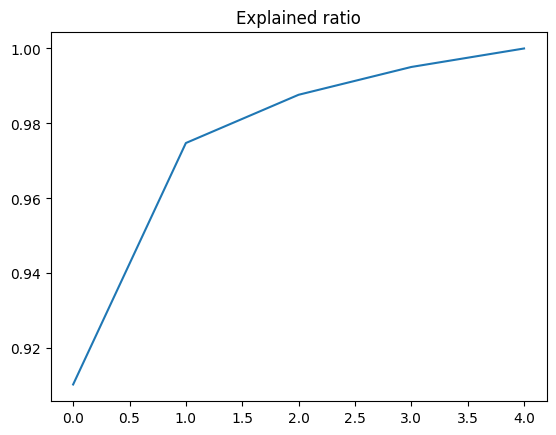

In [6]:
plt.plot(explained_ratio)
plt.title('Explained ratio')
plt.show()

In [7]:
coeff = pd.DataFrame(pca.components_, columns=['x', 'y', 'rx', 'ry', 'rz'], index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
coeff

,x,y,rx,ry,rz
PC1,0.010642,-0.954987,0.017895,-0.294883,-0.024705
PC2,0.132064,0.294577,0.104879,-0.940015,-0.034002
PC3,-0.023011,0.014182,-0.992008,-0.111378,0.052769
PC4,-0.347042,0.023329,-0.040088,-0.012039,-0.936625
PC5,0.928159,-0.021890,-0.054711,0.129869,-0.343778


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np

## Data

In [9]:
# data = torch.rand((600, 3)) # data for the model (N, variables) where N is the total number of samples and variables the number of input to consider
# target = torch.randint(0, 4, (600,)) # target values from 0 to 3 == to 4 different categories

# data = np.random.rand(600, 3).astype('float32')
# target = np.random.randint(4, size=(600,)).astype('float32')

data = df.iloc[:,[1,2,3,4,5,6]]
data = (data - data.mean())/data.std()
data = data.to_numpy().astype('float32')
target = df.iloc[:, 0].to_numpy() -1

print(f'There are {data.shape[1]} variables in consideration with {data.shape[0]} number of samples (N)')
# print(f'There are a total of {len(target.unique())} categories')
print(f'There are a total of {len(np.unique(target))} categories')

There are 6 variables in consideration with 560 number of samples (N)
There are a total of 4 categories


In [10]:
class CustomDataset(Dataset):
    def __init__ (self, data, target, seq_length, transform=None):

        self.data = data.reshape((-1, seq_length, data.shape[-1])) # [N, 3] ==> [test, seq_length, variables] --> [T, 20, 3]
        self.target = np.mean(target.reshape((-1,seq_length)), axis=1) # [N,] ==> [test,]

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Select elements
        value = self.data[idx]
        target = self.target[idx]

        if self.transform is not None:
            value = self.transform(value)
            # target = self.transform(target)

        return value, target

In [11]:
SEQ_LENGTH = 20
BATCH_SIZE = 8

dataset = CustomDataset(data, target, SEQ_LENGTH, transform=torch.from_numpy)
num_test = len(dataset)
print(f'There are a total of {num_test} test in dataset')

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

value, target = next(iter(train_loader))
print(f'Data: {value.shape}')
print(f'Target: {target.shape}')

There are a total of 28 test in dataset
Data: torch.Size([8, 20, 6])
Target: torch.Size([8])


## Network architecture

In [82]:
class AlignmentNet(nn.Module):
    def __init__(self, params):
        super(AlignmentNet, self).__init__()

        # Load parameters
        self.input_size = params['input_size']
        self.num_layers = params['num_layers']
        self.hidden_size = params['hidden_size']
        self.output_channels = params['output_channels']

        # Define network layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size//2)
        self.fc2 = nn.Linear(self.hidden_size//2, self.output_channels)

        # Special layers
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden weights
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0)) # out has shape [batch_size, seq_length, hidden_size]
        out = out[:, -1, :] # out [batch_size, hidden_size]

        x = self.relu(self.fc1(out))
        x = self.relu(self.fc2(x))

        return x

net_params = {
    'input_size': 6,
    'seq_length':20,
    'num_layers': 2,
    'hidden_size': 128,
    'output_channels': 4
}
model = AlignmentNet(net_params) # inputs [batch_size, seq_lenght, input_size] --> [batch_size, 20, 4]

print(model)

AlignmentNet(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)


## Hyper parameters

In [83]:
MAX_EPOCHS = 200
lr = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.8)
loss_fn = nn.CrossEntropyLoss()

In [84]:
def train(model, train_loader, optimizer, loss_fn, max_epoch, val_loader = None):
    metrics_hist = {
        'loss': [],
        'accuracy': [],
    }
    
    for e in range(max_epoch):
        # Metrics over 1 epoch
        acc_accuracy = 0
        acc_loss = 0
        for i, (data, target) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()

            prediction = model(data) # prediction [batch_size, output_channels (3)]

            loss_value = loss_fn(prediction, target.long())

            loss_value.backward()
            optimizer.step()

            # AQUIIII MIRAR EL VALOR DE pred Y COMPARLO CON target. pred deberia ir entre [0,3] y corresponderia con target
            # Calculate accuracy
            prediction = F.softmax(prediction, dim=0)
            pred = torch.argmax(prediction, dim=1) # [batchsize,]

            acc_accuracy += (pred == target).sum()/len(target)
            acc_loss += loss_value.item()


        avg_loss = acc_loss / len(train_loader)
        avg_acc = acc_accuracy / len(train_loader)
        metrics_hist['loss'].append(avg_loss)
        metrics_hist['accuracy'].append(avg_acc)

        if e % 20 == 0:
            print(f'Epoch {e+1}/{max_epoch}')
            print(f'Training Loss: {avg_loss} \t | \t Training accuracy: {avg_acc * 100}')

        if val_loader is not None:
            validation_loop(model, val_loader, loss_fn)

    return metrics_hist, model



def validation_loop(model, val_loader, loss_fn):
    with torch.no_grad():
        model.eval()
        for i, (data, target) in enumerate(val_loader):
            prediction = model(data)
            loss_value = loss_fn(prediction, target)


In [85]:
metrics, res_model = train(model, train_loader, optimizer, loss_fn, MAX_EPOCHS)

Epoch 1/200
Training Loss: 1.3897071182727814 	 | 	 Training accuracy: 34.375
Epoch 21/200
Training Loss: 1.387252151966095 	 | 	 Training accuracy: 40.625
Epoch 41/200
Training Loss: 1.382426381111145 	 | 	 Training accuracy: 37.5
Epoch 61/200
Training Loss: 1.381823718547821 	 | 	 Training accuracy: 31.25
Epoch 81/200
Training Loss: 1.384292095899582 	 | 	 Training accuracy: 34.375
Epoch 101/200
Training Loss: 1.38811793923378 	 | 	 Training accuracy: 31.25
Epoch 121/200
Training Loss: 1.384345680475235 	 | 	 Training accuracy: 34.375
Epoch 141/200
Training Loss: 1.3803819715976715 	 | 	 Training accuracy: 31.25
Epoch 161/200
Training Loss: 1.3770336508750916 	 | 	 Training accuracy: 34.375
Epoch 181/200
Training Loss: 1.384454756975174 	 | 	 Training accuracy: 34.375


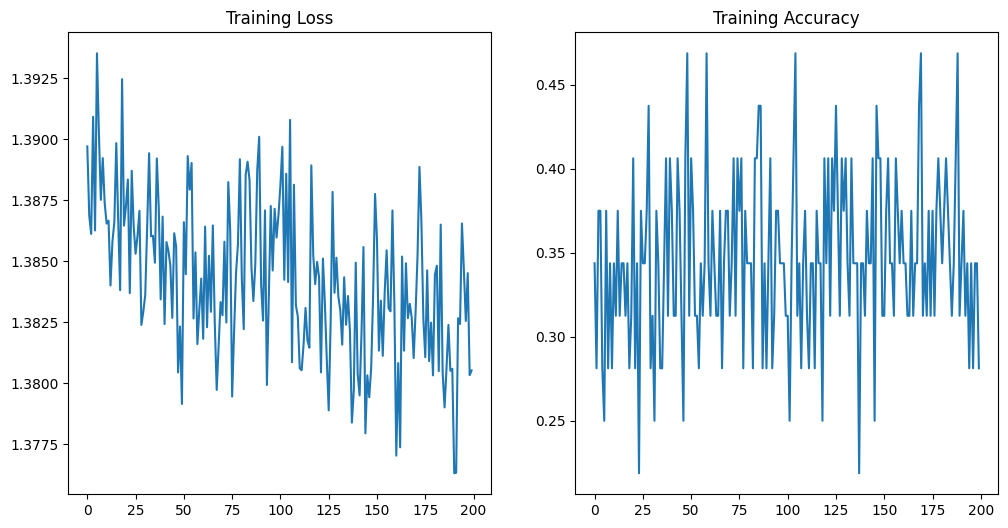

In [86]:
loss, acc = metrics['loss'], metrics['accuracy']

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss)
ax[0].set_title('Training Loss')

ax[1].plot(acc)
ax[1].set_title('Training Accuracy')

plt.show()

In [87]:
print('Average loss: ', np.mean(loss))
print('Average Accuracy: ', np.mean(acc))

Average loss:  1.3842566922307014
Average Accuracy:  0.34640625
